In [2]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')

In [3]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm
def calculate_flux_density(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_intensity(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

In [4]:
def CountPixel(img, x, y, boundary, lenth = 30):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    return len(np.where(img > boundary)[0])

In [5]:
def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [6]:
with open("BOSS2239_NB.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('2239nb1.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [7]:
with open("BOSS2239_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('2239bw1.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [8]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS_Bw=pd.read_csv("BOSS2239_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS_NB=pd.read_csv("BOSS2239_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])

In [9]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)


SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']


In [10]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
coord_bw=SkyCoord(ra=BOSS_Bw['ALPHA_J2000']*u.degree, dec=BOSS_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS_NB['ALPHA_J2000']*u.degree, dec=BOSS_NB['DELTA_J2000']*u.degree)

In [11]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)
index = np.where((d2d < Angle('0d00m01s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))
idx=idx[index]

In [12]:
SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj
SDSS6_bmag=SDSS6.bmag.data.obj
BOSS_Bw_list=BOSS_Bw.MAG_APER.data.obj
BOSS_Bw_list_standard=BOSS_Bw.MAG_APER.data.obj[idx]

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.data is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be rem

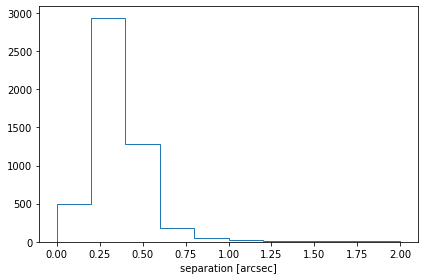

In [13]:
plt.hist(d2d.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()

In [14]:
SDSS6_bmag_standard=SDSS6_bmag[index]
zeropoint_bw=SDSS6_bmag_standard-BOSS_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

Bw的zeropoint为 28.113404516188293
Bw的standard deviation为 0.0997366717104834


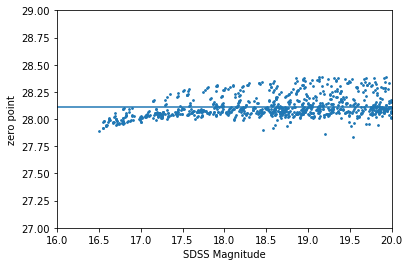

In [15]:
# zeropoint_bw.zeropoint_bw.data.obj
zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation


print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')
plt.axis([16,20,27,29])
plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)

plt.show()

In [16]:
BOSS_Bw=pd.concat([BOSS_Bw,BOSS_Bw.MAG_APER+zp_bw],axis=1)
BOSS_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [17]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)
index_nb = np.where(d2d_nb < Angle('0d0m01s'))
idx_nb=idx_nb[index_nb]

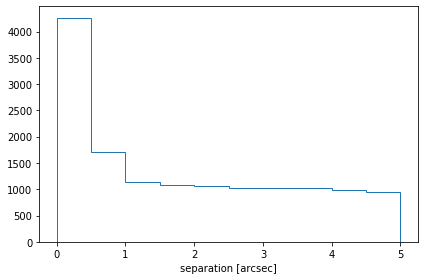

In [18]:
plt.hist(d2d_nb.arcsec, histtype='step', range=(0,5))
plt.xlabel('separation [arcsec]')
plt.tight_layout()

In [19]:
BOSS_NB_match = BOSS_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS_NB_match < 5) &(BOSS_NB_match > -3))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.data is deprecated and will be removed in a future version
  


In [20]:
zp_nb=np.mean(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))
zp_std_nb=np.std(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))

NB的zeropoint为 22.660109278093056
NB的standard deviation为 0.004165139856316211


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.data is deprecated and will be removed in a future version
  if __name__ == '__main__':


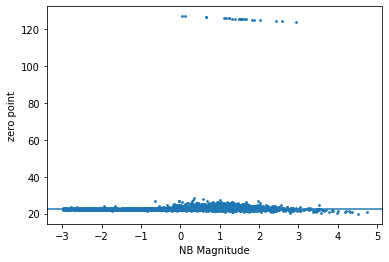

In [21]:
print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

BOSS_NB=pd.concat([BOSS_NB,BOSS_NB.MAG_APER+zp_nb],axis=1)
BOSS_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

BOSS_NB_match=BOSS_NB_match+zp_nb

b_nb=BOSS_Bw.standard_mag.data.obj[idx_nb]-BOSS_NB_match
mag_nb_draw=BOSS_NB_match

plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')

plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)

plt.show()


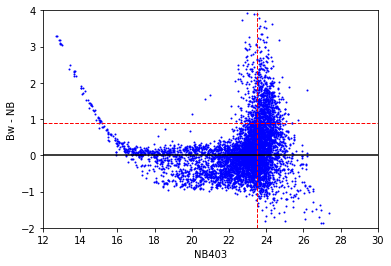

In [22]:
plt.scatter(mag_nb_draw, b_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(23.5, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [23]:
BOSS_Bw_ALPHA=BOSS_Bw.ALPHA_J2000.data.obj[idx_nb]
BOSS_Bw_DELTA=BOSS_Bw.DELTA_J2000.data.obj[idx_nb]
BOSS_Bw_X_IMAGE=BOSS_Bw.X_IMAGE.data.obj[idx_nb]
BOSS_Bw_Y_IMAGE=BOSS_Bw.Y_IMAGE.data.obj[idx_nb]
BOSS_Bw_ISOAREAF_IMAGE=BOSS_Bw.ISOAREAF_IMAGE.data.obj[idx_nb]

BOSS_NB_ALPHA=BOSS_NB.ALPHA_J2000.data.obj[index_nb]
BOSS_NB_DELTA=BOSS_NB.DELTA_J2000.data.obj[index_nb]
BOSS_NB_X_IMAGE=BOSS_NB.X_IMAGE.data.obj[index_nb]
BOSS_NB_Y_IMAGE=BOSS_NB.Y_IMAGE.data.obj[index_nb]
BOSS_NB_ISOAREAF_IMAGE=BOSS_NB.ISOAREAF_IMAGE.data.obj[index_nb]

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.data is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be rem

In [24]:
BOSS_Bw_X_IMAGE_dubious=[]
BOSS_Bw_Y_IMAGE_dubious=[]
BOSS_Bw_RA_dubious=[]
BOSS_Bw_DEC_dubious=[]
BOSS_Bw_mag_dubious=[]
BOSS_Bw_AREA_dubious=[]

BOSS_NB_X_IMAGE_dubious=[]
BOSS_NB_Y_IMAGE_dubious=[]
BOSS_NB_RA_dubious=[]
BOSS_NB_DEC_dubious=[]
BOSS_NB_mag_dubious=[]
BOSS_NB_AREA_dubious=[]

for i in range(len(idx_nb)):
    if (BOSS_Bw.standard_mag.data.obj[idx_nb][i]-BOSS_NB_match[i] > 0.9) \
        & (BOSS_NB_match[i]< 23.5):
        BOSS_Bw_X_IMAGE_dubious.append(BOSS_Bw_X_IMAGE[i])
        BOSS_Bw_Y_IMAGE_dubious.append(BOSS_Bw_Y_IMAGE[i])
        BOSS_Bw_RA_dubious.append(BOSS_Bw_ALPHA[i])
        BOSS_Bw_DEC_dubious.append(BOSS_Bw_DELTA[i])
        BOSS_Bw_mag_dubious.append(BOSS_Bw.standard_mag.data.obj[idx_nb][i])
        BOSS_Bw_AREA_dubious.append(BOSS_Bw_ISOAREAF_IMAGE[i])
        
        BOSS_NB_X_IMAGE_dubious.append(BOSS_NB_X_IMAGE[i])
        BOSS_NB_Y_IMAGE_dubious.append(BOSS_NB_Y_IMAGE[i])
        BOSS_NB_RA_dubious.append(BOSS_NB_ALPHA[i])
        BOSS_NB_DEC_dubious.append(BOSS_NB_DELTA[i])
        BOSS_NB_mag_dubious.append(BOSS_NB_match[i])
        BOSS_NB_AREA_dubious.append(BOSS_NB_ISOAREAF_IMAGE[i])

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.data is deprecated and will be removed in a future version
  app.launch_new_instance()
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.data is deprecated and will be removed in a future version


In [25]:
w = WCS('2239bwcut1.fits')
data,header=fits.getdata('2239bwcut1.fits',header=True)
data2,header2=fits.getdata('2239nbcut1.fits',header=True)
lenx=len(data[0])
leny=len(data)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
norm = Scaleimgconverter(datacut)

In [26]:
x_select=[]
y_select=[]
ra_select=[]
dec_select=[]
mag_nb_select=[]
mag_bw_select=[]
for i in range(len(BOSS_NB_X_IMAGE_dubious)):
    if (BOSS_NB_AREA_dubious[i]>25) and (choose(datacut,BOSS_NB_X_IMAGE_dubious[i],BOSS_NB_Y_IMAGE_dubious[i],-10,40)):
        x_select.append(BOSS_NB_X_IMAGE_dubious[i])
        y_select.append(BOSS_NB_Y_IMAGE_dubious[i])
        ra_select.append(BOSS_NB_RA_dubious[i])
        dec_select.append(BOSS_NB_DEC_dubious[i])
        mag_nb_select.append(BOSS_NB_mag_dubious[i])
        mag_bw_select.append(BOSS_Bw_mag_dubious[i])
        
print(len(x_select))

51


In [27]:
for i in range(len(x_select)-1,-1,-1):
    if (x_select[i]>3700) and (x_select[i]<6200):
        if (y_select[i]>4900) and (y_select[i]<6000):
            del x_select[i]
            del y_select[i]
            del ra_select[i]
            del dec_select[i]
            del mag_nb_select[i]
            del mag_bw_select[i]
            

In [28]:
with open("BOSS2239.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(mag_nb_select)):
        if (mag_bw_select[i]-mag_nb_select[i] > 0.9) \
        & (mag_nb_select[i]< 23.5):
            txtfile.write('circle(')
            txtfile.write(str(ra_select[i]))
            txtfile.write(',')
            txtfile.write(str(dec_select[i]))
            txtfile.write(',2.821")\n')

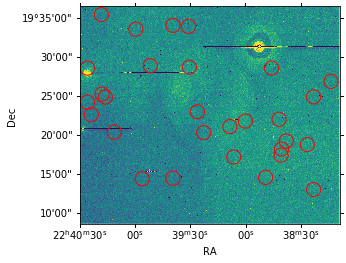

<Figure size 432x288 with 0 Axes>

In [29]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')
ax.scatter(x_select, y_select, color='', marker='o', edgecolors='r', s=200)

In [33]:
for i in range(len(x_select)):
    print(i)
    print(x_select[i])
    print(y_select[i])
    print(' ')

0
7194.9849
1054.407
 
1
1920.844
1386.3203
 
2
2863.1807
1401.0371
 
3
5715.5391
1426.9069
 
4
4735.2383
2053.6455
 
5
6191.7769
2112.3525
 
6
6209.4258
2298.8877
 
7
6999.8091
2437.8694
 
8
6349.6943
2544.8125
 
9
3811.0681
2803.947
 
10
1062.9578
2816.1267
 
11
4617.6636
2989.7561
 
12
5094.6265
3159.9133
 
13
6128.582
3215.9062
 
14
353.6454
3353.8962
 
15
3618.2405
3446.7412
 
16
233.9359
3739.5427
 
17
785.3796
3899.1138
 
18
7192.6899
3905.7241
 
19
685.8638
3989.7881
 
20
7727.9995
4383.1504
 
21
230.6168
4791.0522
 
22
5894.6621
4792.502
 
23
3371.1548
4818.6567
 
24
2168.3472
4865.0488
 
25
3342.8313
6074.7866
 
26
1724.2716
5987.4395
 
27
662.9786
6436.9785
 
28
2865.6619
6104.647
 


x_image: 6209.4258 

y_image: 2298.8877 

RA: 339.6683933 

DEC: 19.302571899999997 

nb_magnitude: 20.718809278093055 

bw_magnitude: 22.285104516188294 



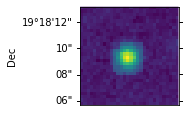

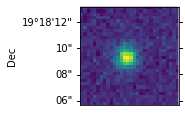

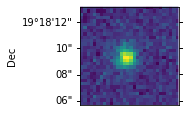

In [38]:
center=[np.array([x_select[6]],float),np.array([y_select[6]],float)]

print('x_image:',x_select[6],'\n')
print('y_image:',y_select[6],'\n')
print('RA:',ra_select[6],'\n')
print('DEC:',dec_select[6],'\n')
print('nb_magnitude:',mag_nb_select[6],'\n')
print('bw_magnitude:', mag_bw_select[6],'\n')

size=30

cutout1=Cutout2D(data, center, size, wcs = WCS(header))
cutout2=Cutout2D(data2, center, size, wcs = WCS(header))
cutout3=Cutout2D(datacut, center, size, wcs = WCS(header))

fig = plt.figure()
ax = plt.subplot(131,projection=cutout1.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout1.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

fig = plt.figure()
ax = plt.subplot(132,projection=cutout2.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout2.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

fig = plt.figure()
ax = plt.subplot(133,projection=cutout3.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout3.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

x_image: 3342.8313 

y_image: 6074.7866 

RA: 339.8793091 

DEC: 19.5648974 

nb_magnitude: 20.024609278093056 

bw_magnitude: 21.154304516188294 



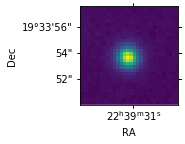

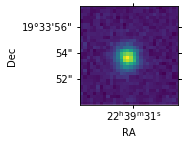

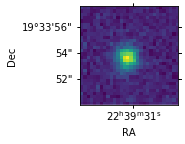

In [37]:
center=[np.array([x_select[25]],float),np.array([y_select[25]],float)]

print('x_image:',x_select[25],'\n')
print('y_image:',y_select[25],'\n')
print('RA:',ra_select[25],'\n')
print('DEC:',dec_select[25],'\n')
print('nb_magnitude:',mag_nb_select[25],'\n')
print('bw_magnitude:', mag_bw_select[25],'\n')

size=30

cutout1=Cutout2D(data, center, size, wcs = WCS(header))
cutout2=Cutout2D(data2, center, size, wcs = WCS(header))
cutout3=Cutout2D(datacut, center, size, wcs = WCS(header))

fig = plt.figure()
ax = plt.subplot(131,projection=cutout1.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout1.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

fig = plt.figure()
ax = plt.subplot(132,projection=cutout2.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout2.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

fig = plt.figure()
ax = plt.subplot(133,projection=cutout3.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout3.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

x_image: 4617.6636 

y_image: 2989.7561 

RA: 339.7854855 

DEC: 19.350647 

nb_magnitude: 21.002909278093057 

bw_magnitude: 22.67530451618829 



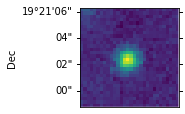

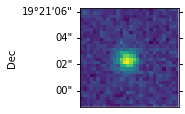

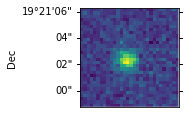

In [39]:
center=[np.array([x_select[11]],float),np.array([y_select[11]],float)]

print('x_image:',x_select[11],'\n')
print('y_image:',y_select[11],'\n')
print('RA:',ra_select[11],'\n')
print('DEC:',dec_select[11],'\n')
print('nb_magnitude:',mag_nb_select[11],'\n')
print('bw_magnitude:', mag_bw_select[11],'\n')

size=30

cutout1=Cutout2D(data, center, size, wcs = WCS(header))
cutout2=Cutout2D(data2, center, size, wcs = WCS(header))
cutout3=Cutout2D(datacut, center, size, wcs = WCS(header))

fig = plt.figure()
ax = plt.subplot(131,projection=cutout1.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout1.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

fig = plt.figure()
ax = plt.subplot(132,projection=cutout2.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout2.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')

fig = plt.figure()
ax = plt.subplot(133,projection=cutout3.wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout3.data,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')